In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nasimeshaghian","key":"5dd317b95f9180c46e6c7250de8fb9dc"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!mv kaggle.json /root/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
!kaggle datasets download -d muhammeddalkran/catvnoncat

Dataset URL: https://www.kaggle.com/datasets/muhammeddalkran/catvnoncat
License(s): unknown
100% 2.66M/2.66M [00:00<00:00, 4.91MB/s]
100% 2.66M/2.66M [00:00<00:00, 4.20MB/s]


In [7]:
!mkdir Dataset

In [8]:
! unzip catvnoncat.zip -d Dataset

Archive:  catvnoncat.zip
  inflating: Dataset/catvnoncat/test_catvnoncat.h5  
  inflating: Dataset/catvnoncat/train_catvnoncat.h5  


In [9]:
def load_dataset():
    train_dataset = h5py.File('Dataset/catvnoncat/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('Dataset/catvnoncat/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [10]:
train_origin , train_origin_y , test_origin , test_origin_y , classes = load_dataset()

In [11]:
train_origin.shape

(209, 64, 64, 3)

y = 0, it's a 'non-cat' picture.


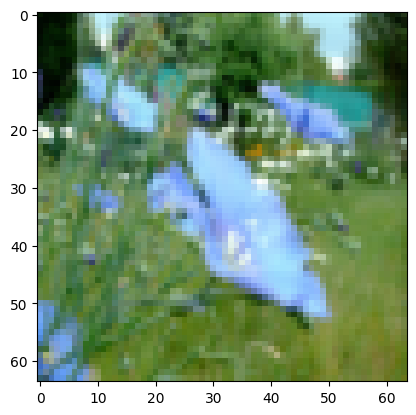

In [12]:
index = 20
plt.imshow(train_origin[index,:])
print ("y = " + str(train_origin_y[0, index]) + ", it's a '" + classes[np.squeeze(train_origin_y[:, index])].decode("utf-8") +  "' picture.")

In [13]:
train_origin_flatten = train_origin.reshape(train_origin.shape[1]*train_origin.shape[2]*train_origin.shape[3] , train_origin.shape[0])
test_origin_flatten = test_origin.reshape(test_origin.shape[1]*test_origin.shape[2]*test_origin.shape[3] , test_origin.shape[0])

In [14]:
train_origin = train_origin_flatten/255
test_origin = test_origin_flatten/255

In [15]:
def sigmoid(z):
  s = 1/(1+np.exp(-z))
  return s

In [16]:
def initialize(dim):
  b = 0
  w = np.zeros((dim,1))
  assert(w.shape == (dim,1))
  assert(isinstance(b,float) or isinstance(b,int))
  return w,b

In [17]:
def propagate(w,b,x,y):
  m = x.shape[1]
  z = np.dot(w.T , x) + b
  A = sigmoid(z)
  cost = np.sum((-np.log(A))*y + (1-y)*(-np.log(1-A)))/m
  dw = (np.dot(x , (A-y).T))/m
  db = (np.sum(A-y))/m

  cost = np.squeeze(cost)

  gradients = {"dw" : dw,
               "db" : db}
  return gradients , cost

In [18]:
def optimize(w ,b ,x ,y ,num_iterations, learning_rate):

  costs = []

  for i in range(num_iterations):
     gradients, cost = propagate(w,b,x,y)
     dw = gradients["dw"]
     db = gradients["db"]
     w = w - learning_rate*dw
     b = b - learning_rate*db
     if i % 100 == 0:
      costs.append(cost)
  params = {"w" : w,
            "b" : b}
  gradients = {"dw" : dw,
               "db" : db}
  return params, gradients, costs

In [19]:
def predict(w, b, x):

  m = x.shape[1]
  y_prediction = np.zeros((1,m))
  w = w.reshape(x.shape[0] , 1)
  z = np.dot(w.T , x) + b
  A = sigmoid(z)
  y_prediction = (A >= 0.5) * 1.0


  return y_prediction

In [20]:
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5):

  w, b = initialize(x_train.shape[0])
  params, gradients, costs = optimize(w, b, x_train, y_train, num_iterations, learning_rate)

  w = params["w"]
  b = params["b"]

  y_train_predict = predict(w, b, x_train)
  y_test_predict = predict(w, b, x_test)

  print("train accuracy: {} %".format(100 - np.mean(np.abs(y_train_predict - y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(y_test_predict - y_test)) * 100))


  d = {"costs": costs,
       "y_train_predict": y_train_predict,
        "y_test_predict" : y_test_predict,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations}
  return d

In [21]:
d = model(train_origin, train_origin_y, test_origin, test_origin_y, num_iterations = 2000, learning_rate = 0.005)


train accuracy: 91.38755980861244 %
test accuracy: 34.0 %


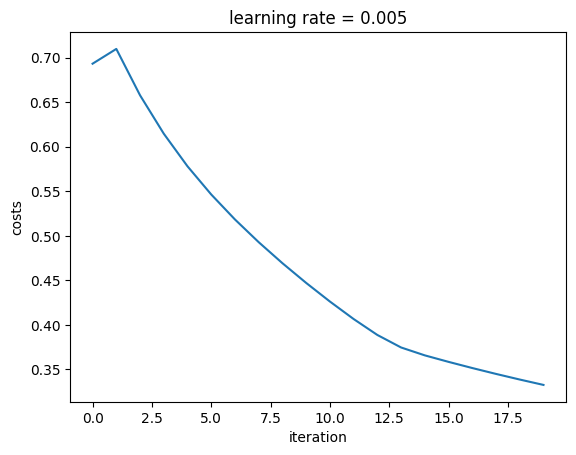

In [22]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('costs')
plt.xlabel('iteration')
plt.title('learning rate = ' + str(d['learning_rate']))
plt.show()

train accuracy: 73.6842105263158 %
test accuracy: 34.0 %
train accuracy: 74.64114832535886 %
test accuracy: 34.0 %
train accuracy: 66.98564593301435 %
test accuracy: 34.0 %


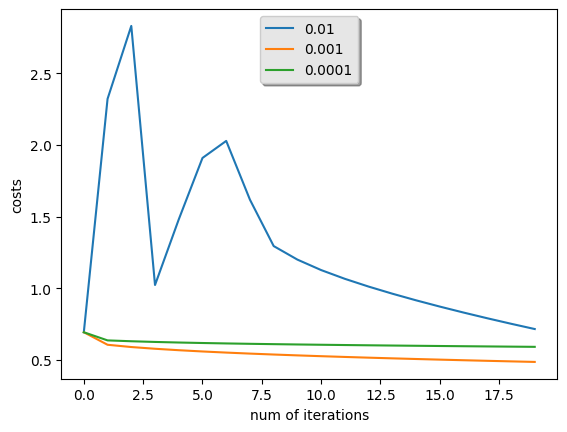

In [28]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for i in learning_rates:
  models[str(i)] = model(train_origin, train_origin_y, test_origin, test_origin_y, num_iterations = 2000, learning_rate = i)
  plt.plot(np.squeeze(models[str(i)]["costs"]), label = models[str(i)]["learning_rate"])

plt.ylabel('costs')
plt.xlabel('num of iterations')
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()